In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
start_date='2015-04-01'
end_date='2023-4-23'
ticker='NVDA'

In [3]:
#warnings.filterwarnings("ignore")
df=yf.download(ticker,start=start_date,end=end_date)
price=df[['Adj Close']]
lags=5
for lag in range(1,1+lags):
    name='lag_{}'.format(lag)
    price[name]=price['Adj Close'].shift(lag)
#warnings.filterwarnings("default")

[*********************100%***********************]  1 of 1 completed


In [5]:
price.dropna(inplace=True)

In [6]:
price.head(3)

,Adj Close,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2015-04-09,5.431311,5.308363,5.269793,5.223990,5.076937,5.064883
2015-04-10,5.486756,5.431311,5.308363,5.269793,5.223990,5.076937
2015-04-13,5.436131,5.486756,5.431311,5.308363,5.269793,5.223990


In [15]:
warnings.filterwarnings("ignore")
price2=df[['Adj Close']]
price2.rename(columns={'Adj Close':'NVDA'})
price2['Return']=np.log(price2/price2.shift(1))
price2.dropna(inplace=True)
price2['direction']=np.sign(price2['Return']).astype(int)
warnings.filterwarnings("default")
price2.head(3)

,Adj Close,Return,direction
Date,,,
2015-04-02,5.076937,0.002377,1
2015-04-06,5.223990,0.028553,1
2015-04-07,5.269793,0.008730,1


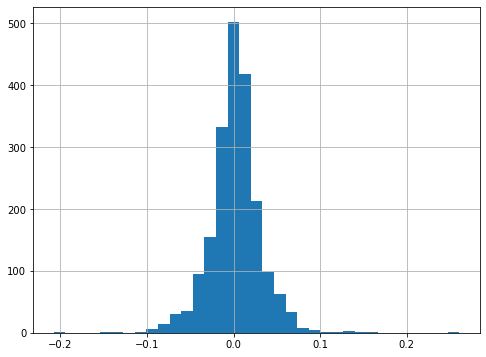

In [16]:
warnings.filterwarnings("ignore")
price2['Return'].hist(bins=35,figsize=(8,6))
warnings.filterwarnings("default")

In [17]:
def create_lags(df,lags):
    global cols
    cols=[]
    for lag in range(1,1+lags):
        col='lag_{}'.format(lag)
        df[col]=df['Return'].shift(lag)
        cols.append(col)
    df.dropna(inplace=True)
    return df
create_lags(price2,2)

/tmp/ipykernel_329017/3679026393.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col]=df['Return'].shift(lag)


,Adj Close,Return,direction,lag_1,lag_2
Date,,,,,
2015-04-02,5.076937,0.002377,1,NaN,NaN
2015-04-06,5.223990,0.028553,1,0.002377,NaN
2015-04-07,5.269793,0.008730,1,0.028553,0.002377
2015-04-08,5.308363,0.007292,1,0.008730,0.028553
2015-04-09,5.431311,0.022897,1,0.007292,0.008730
...,...,...,...,...,...
2023-04-17,270.019989,0.009077,1,0.011086,-0.001209
2023-04-18,276.670013,0.024330,1,0.009077,0.011086
2023-04-19,279.309998,0.009497,1,0.024330,0.009077


In [45]:
train_x.shape

(1867, 2)

In [51]:
price2.dropna(inplace=True)
from sklearn.linear_model import LinearRegression
model=LinearRegression()
train_x=price2.loc['2015-04-07':'2022-09-01',cols]
train_y1=price2.loc['2015-04-07':'2022-09-01','Return']
train_y2=price2.loc['2015-04-07':'2022-09-01','direction']

test_x=price2.loc['2022-09-02':'2023-04-04',cols]
test_y1=price2.loc['2022-09-02':'2023-04-04','Return']
test_y2=price2.loc['2022-09-02':'2023-04-04','direction']
model1=model.fit(train_x,train_y1)
model2=model.fit(train_x,train_y2)
#price2['ols_1']=model1.predict(test_x)
#price2['ols_2']=model2.predict(test_x)
#price2[['ols_1','ols_2']].head(3)
predicted=pd.DataFrame(columns=['ols_1','ols_2'],
                       index=test_x.index)
predicted['ols_1']=model1.predict(test_x)
predicted['ols_2']=model2.predict(test_x)

/usr/lib/python3/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [53]:
new_price=pd.DataFrame(np.where(predicted[['ols_1','ols_2']]>0,1,-1),index=test_x.index)
new_price.columns=['ols_1','ols_2']
#new_price.rename(columns={'0':'ols1','1':'ols2'},inplace=True)
new_price.head(3)

,ols_1,ols_2
Date,,
2022-09-02,1,1
2022-09-06,1,1
2022-09-07,1,1


In [54]:
new_price['ols_1'].value_counts()

 1    127
-1     20
Name: ols_1, dtype: int64

In [55]:
new_price['ols_2'].value_counts()

 1    127
-1     20
Name: ols_2, dtype: int64

In [56]:
new_price['strat_ols1']=new_price['ols_1']*price2.loc['2022-09-02':'2023-04-04','Return']
new_price['strat_ols2']=new_price['ols_2']*price2.loc['2022-09-02':'2023-04-04','Return']
new_price['strat_ols1'].sum()

0.22015660972174955

In [57]:
new_price['strat_ols2'].sum()

0.22015660972174955

In [59]:
test_y1.sum()

0.6786510543003845

In [63]:
(test_y2==new_price['ols_1']).value_counts()

True     74
False    73
dtype: int64

In [64]:
(test_y2==new_price['ols_2']).value_counts()

True     74
False    73
dtype: int64

/tmp/ipykernel_329017/186989330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price2['strat_ols1']=new_price['strat_ols1']
/tmp/ipykernel_329017/186989330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price2['strat_ols2']=new_price['strat_ols2']


<AxesSubplot:xlabel='Date'>

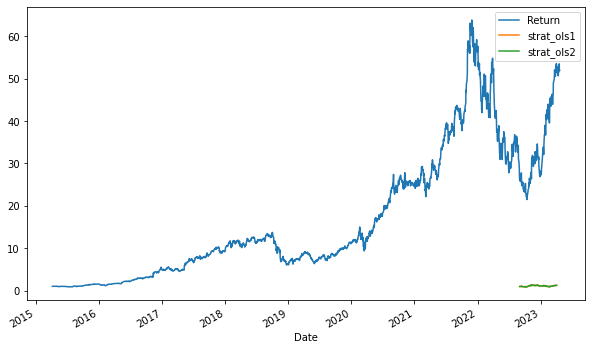

In [65]:
price2['strat_ols1']=new_price['strat_ols1']
price2['strat_ols2']=new_price['strat_ols2']
price2.loc['':'',['Return', 'strat_ols1', 'strat_ols2']].cumsum().apply(np.exp).plot(figsize=(10, 6))